In [1]:
import numpy as np
import pandas as pd

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Data display customization
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Set pretty printing format for floats
pd.set_option('float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading the data into a dataframe

In [2]:
beer_data_df = pd.read_csv('beer_data.csv')
beer_data_df.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.00
1,52159,oline73,3.00
2,52159,alpinebryant,3.00
3,52159,rawthar,4.00
4,52159,RangerClegg,3.50


### Inspecting the data

In [3]:
# Checking the number of records
print('The number of records are: ',len(beer_data_df))

The number of records are:  475984


In [4]:
# Checking for column wise null value percentages
beer_data_df.isnull().sum() * 100 / len(beer_data_df)

beer_beerid          0.00
review_profilename   0.02
review_overall       0.00
dtype: float64

In [5]:
# Removing the null values since it is a very small percentage
beer_data_df = beer_data_df.dropna()
# Checking the null value percentages again
beer_data_df.isnull().sum() * 100 / len(beer_data_df)

beer_beerid          0.00
review_profilename   0.00
review_overall       0.00
dtype: float64

In [6]:
# Checking for duplicate records
len(beer_data_df[beer_data_df.duplicated(["beer_beerid","review_profilename"],keep='first')])

1422

There are 1422 duplicate records. These can be removed.

In [7]:
# Removing the duplicate records.
beer_data_df = beer_data_df[~beer_data_df.duplicated(["beer_beerid","review_profilename"],keep='first')]

In [8]:
print('The number of records left after removing duplicates and null values are: ',len(beer_data_df))

The number of records left after removing duplicates and null values are:  474462


First selecting an appropriate value of N. Will continue with Data Exploration after that.

In [9]:
# Checking the count of distinct beers
print('There are {} distinct beers.'.format(len(beer_data_df['beer_beerid'].unique())))

There are 40304 distinct beers.


In [10]:
# Checking the distribution of number of ratings given to a beer
beer_data_count_beer_rating_df = pd.DataFrame(beer_data_df.groupby('beer_beerid').review_overall.count().sort_values(ascending=False).reset_index())
beer_data_count_beer_rating_df

,beer_beerid,review_overall
0,2093,977
1,412,966
2,1904,902
3,1093,840
4,92,812
5,4083,798
6,276,788
7,7971,778
8,88,755
9,1013,750


The number of reviews for beers is in the range 1 to 977. Beer with beerid 2093 has been reviewed maximum number of times, i.e. 977.

In [11]:
# Describing the frequency distribution of number of reviews by beer
beer_data_count_beer_rating_df.review_overall.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95])

count   40304.00
mean       11.77
std        41.89
min         1.00
5%          1.00
10%         1.00
25%         1.00
50%         2.00
75%         5.00
90%        21.00
95%        51.00
max       977.00
Name: review_overall, dtype: float64

Around 75% of the beers get less than 10 reviews. Only 10% beers get ~41 reviews or more. Most beers get very few reviews and very few beers have the number of reviews large enough to build a recommendation system that doesn't suffer much with the problem of cold start. Choosing a number 100 for the minimum number of reviews for a beer to be considered for building a recommendation system.

In [12]:
# filtering the data by beers that have 100 or more ratings
beer_data_filtered = beer_data_df[beer_data_df.beer_beerid.isin((beer_data_count_beer_rating_df[beer_data_count_beer_rating_df.review_overall >= 50].beer_beerid))]

In [13]:
# checking the percentage of data left
print(round(len(beer_data_filtered)*100/len(beer_data_df),2))

62.39


This leaves with us around 62% of data.

In [14]:
# Checking the count of distinct reviewers
print('There are {} distinct reviewers.'.format(len(beer_data_df['review_profilename'].unique())))

There are 22497 distinct reviewers.


In [15]:
# Checking the distribution of number of beers a user has rated
beer_data_count_user_rated_df = pd.DataFrame(beer_data_df.groupby('review_profilename').review_overall.count().sort_values(ascending=False).reset_index())
beer_data_count_user_rated_df

,review_profilename,review_overall
0,northyorksammy,1842
1,mikesgroove,1373
2,BuckeyeNation,1336
3,Thorpe429,1072
4,ChainGangGuy,1046
5,NeroFiddled,1027
6,womencantsail,1013
7,brentk56,992
8,WesWes,976
9,Phyl21ca,973


The number of beers rated by users range from 1 to 1842. User 'northyorksammy' has rated the most number of beers, i.e. 1842.

In [16]:
# Describing the frequency distribution of number of reviews by user
beer_data_count_user_rated_df.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95])

,review_overall
count,22497.00
mean,21.09
std,65.39
min,1.00
5%,1.00
10%,1.00
25%,1.00
50%,3.00
75%,11.00
90%,48.00


~75% users have rated only 11 beers or fewer. ~25% of the users have rated only 1 beer. Choosing a number 10 for the minimum number of beers reviewed for a user to be considered for building a recommendation system.

In [17]:
# filtering the data by beers that have 100 or more ratings
beer_data_filtered = beer_data_filtered[beer_data_filtered.review_profilename.isin((beer_data_count_user_rated_df[beer_data_count_user_rated_df.review_overall >= 100].review_profilename))]

In [18]:
# checking the percentage of data left
print(round(len(beer_data_filtered)*100/len(beer_data_df),2))

32.08


We have ~32% data left after filtering the data for beers which have more than or equal to 50 reviews, and users that have rated more than or equal to 100 beers. This data will be used for exploration and building the recommendation system.

### Data Exploration

In [19]:
# Checking the unique values of the ratings.
sorted(beer_data_filtered.review_overall.unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

There are 9 unique values for the ratings given by the users.

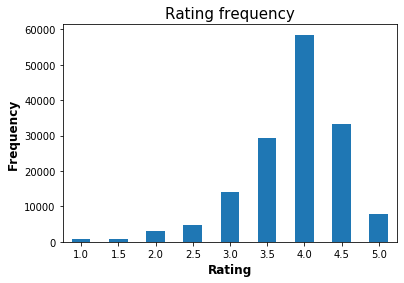

In [20]:
# visualising the distribution of ratings received by beers
rating_beer_plot = beer_data_filtered.groupby('review_overall').beer_beerid.count().plot(kind='bar', title='Rating frequency',rot=0)
_ = rating_beer_plot.title.set_size(15)
_ = rating_beer_plot.set_xlabel("Rating",fontsize=12,fontweight='bold')
_ = rating_beer_plot.set_ylabel("Frequency",fontsize=12,fontweight='bold')

4 is the rating received by the maximum number of beers, followed by 4.5 and 3.5. 1 rating is given to the least number of beers. It can be derived that most reviewers give a high rating to the beers in general.

In [21]:
# The average beer ratings
avg_beer_rating_df = pd.DataFrame(beer_data_filtered.groupby('beer_beerid').review_overall.mean().sort_values(ascending=False))
avg_beer_rating_df

,review_overall
beer_beerid,
16814,4.63
1545,4.59
36316,4.59
1062,4.54
21690,4.53
7971,4.53
23030,4.53
731,4.52
857,4.50


The average beer ratings range from 1.73 to 4.63

In [22]:
# The average user ratings
avg_user_rating_df = pd.DataFrame(beer_data_filtered.groupby('review_profilename').review_overall.mean().sort_values(ascending=False))
avg_user_rating_df

,review_overall
review_profilename,
EnojysAnyBeer,4.44
mempath,4.37
MattyG85,4.36
TommyW,4.35
scootny,4.31
Deuane,4.29
saintwarrick,4.27
Beerenauslese,4.25
hoplover82,4.25


The average user ratings range from 3.04 to 4.44.

In [23]:
# The average number of ratings given to the beers.
count_beer_rating_df = pd.DataFrame(beer_data_filtered.groupby('beer_beerid').review_overall.count().sort_values(ascending=False))
print('The average number of ratings given to beers is',round(np.mean(count_beer_rating_df.review_overall),0))

The average number of ratings given to beers is 74.0


In [24]:
# The average number of ratings given by a user.
count_user_rating_df = pd.DataFrame(beer_data_filtered.groupby('review_profilename').review_overall.count().sort_values(ascending=False))
print('The average number of ratings given by a user is',round(np.mean(count_user_rating_df.review_overall),0))

The average number of ratings given by a user is 132.0


### Dividing the dataset into train and test

In [25]:
from sklearn.model_selection import train_test_split
beer_train, beer_test = train_test_split(beer_data_filtered, test_size=0.30, random_state=42)

In [26]:
print(beer_train.shape)
print(beer_test.shape)

(106555, 3)
(45667, 3)


In [27]:
# # pivot ratings into beer features
df_beer_features = beer_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)
df_beer_features.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3Vandoo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99bottles,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,4.50,4.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADZA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
# copying train and test data
dummy_beer_train = beer_train.copy()
dummy_beer_test = beer_test.copy()

In [29]:
# dummy_train will be used for prediction
dummy_beer_train['review_overall'] = dummy_beer_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
# dummy test will be used for evaluation
dummy_beer_test['review_overall'] = dummy_beer_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [30]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_beer_train = dummy_beer_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The movies not rated by user is marked as 0 for evaluation. 
dummy_beer_test = dummy_beer_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [31]:
dummy_beer_train.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3Vandoo,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
99bottles,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
ADR,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
ADZA,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [32]:
dummy_beer_test.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3Vandoo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99bottles,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADZA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### User based similarity

#### Using cosine similarity

In [33]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_similarity_matrix = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_similarity_matrix[np.isnan(user_similarity_matrix)] = 0
print(user_similarity_matrix)

[[1.         0.02000148 0.11364478 ... 0.06840037 0.06170333 0.06473218]
 [0.02000148 1.         0.09327367 ... 0.06661627 0.         0.        ]
 [0.11364478 0.09327367 1.         ... 0.072623   0.04014679 0.09587514]
 ...
 [0.06840037 0.06661627 0.072623   ... 1.         0.09874305 0.08683379]
 [0.06170333 0.         0.04014679 ... 0.09874305 1.         0.02896692]
 [0.06473218 0.         0.09587514 ... 0.08683379 0.02896692 1.        ]]


This is also taking into consideration those beers which a user hasn't rated. Also, this isn't taking into consideration the fact that different reviewers might have different rating standards. Adjusted cosine similarity can be used to take care of these two things.

In [34]:
# Adjusted cosine similarity
beer_features = beer_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
beer_features.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,nan,nan,nan,4.00,nan,nan,nan,nan,nan,nan,5.00,nan,nan,4.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3Vandoo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.00,nan,nan,nan,4.00,nan,nan,nan,4.50,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99bottles,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADR,nan,nan,nan,nan,nan,nan,nan,nan,5.00,nan,nan,nan,4.50,4.00,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ADZA,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,3.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [35]:
# Normalizing the rating of the beer for each reviewer around 0 mean
mean = np.nanmean(beer_features, axis=1)
subtracted_df = (beer_features.T-mean).T

# User Similarity Matrix
user_similarity_matrix = 1 - pairwise_distances(subtracted_df.fillna(0), metric='cosine')
user_similarity_matrix[np.isnan(user_similarity_matrix)] = 0
print(user_similarity_matrix)

[[ 1.          0.00734809  0.05564559 ...  0.02405263  0.04550059
   0.03416657]
 [ 0.00734809  1.         -0.02552392 ...  0.00529247  0.
   0.        ]
 [ 0.05564559 -0.02552392  1.         ...  0.074229    0.0145143
   0.0178889 ]
 ...
 [ 0.02405263  0.00529247  0.074229   ...  1.          0.03387749
   0.12632911]
 [ 0.04550059  0.          0.0145143  ...  0.03387749  1.
   0.01544339]
 [ 0.03416657  0.          0.0178889  ...  0.12632911  0.01544339
   1.        ]]


The above matrix gives us the similarity between different users. Checking the similarity between first 10 users.

In [36]:
# Similarity between first 10 users
user_similarity_matrix[:10,:10]

array([[ 1.        ,  0.00734809,  0.05564559, -0.00358348,  0.01832848,
         0.0579246 ,  0.05816354, -0.0025624 ,  0.00278278,  0.00924223],
       [ 0.00734809,  1.        , -0.02552392, -0.01181306,  0.00797917,
         0.        ,  0.        ,  0.        ,  0.00139   ,  0.00787169],
       [ 0.05564559, -0.02552392,  1.        , -0.0074407 ,  0.01303423,
         0.01761955, -0.02645309, -0.01418747,  0.00255443,  0.02842439],
       [-0.00358348, -0.01181306, -0.0074407 ,  1.        ,  0.02905912,
         0.04358443,  0.02888542, -0.0023948 ,  0.00354668,  0.04228957],
       [ 0.01832848,  0.00797917,  0.01303423,  0.02905912,  1.        ,
         0.04360615,  0.01224743,  0.00142347,  0.01779494,  0.        ],
       [ 0.0579246 ,  0.        ,  0.01761955,  0.04358443,  0.04360615,
         1.        ,  0.02924795,  0.06127799, -0.00489445, -0.01639006],
       [ 0.05816354,  0.        , -0.02645309,  0.02888542,  0.01224743,
         0.02924795,  1.        , -0.00072715

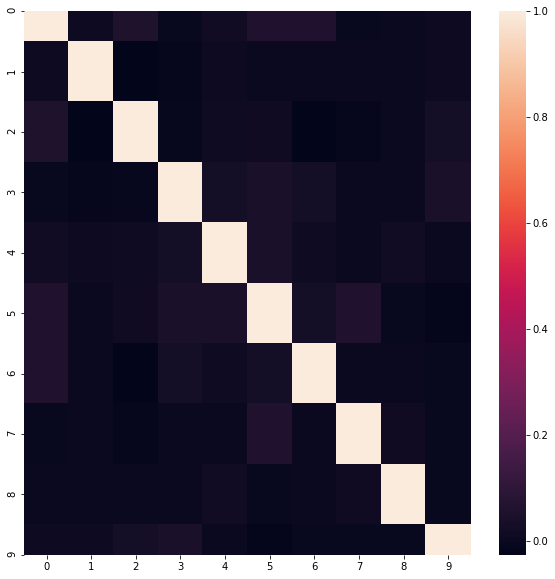

In [37]:
# Plotting the similarity between first 10 users

x=pd.DataFrame(user_similarity_matrix[:10,:10])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(x, annot=False, ax=ax)

### Prediction for user based similarity

In [38]:
# Prediction will be done for users which are positively related with other users, and not the users which are negatively related.
user_similarity_matrix[user_similarity_matrix<0]=0
user_similarity_matrix

array([[1.        , 0.00734809, 0.05564559, ..., 0.02405263, 0.04550059,
        0.03416657],
       [0.00734809, 1.        , 0.        , ..., 0.00529247, 0.        ,
        0.        ],
       [0.05564559, 0.        , 1.        , ..., 0.074229  , 0.0145143 ,
        0.0178889 ],
       ...,
       [0.02405263, 0.00529247, 0.074229  , ..., 1.        , 0.03387749,
        0.12632911],
       [0.04550059, 0.        , 0.0145143 , ..., 0.03387749, 1.        ,
        0.01544339],
       [0.03416657, 0.        , 0.0178889 , ..., 0.12632911, 0.01544339,
        1.        ]])

In [39]:
user_predicted_ratings = np.dot(user_similarity_matrix, beer_features.fillna(0))
user_predicted_ratings

array([[3.55626526, 4.72377258, 2.92336829, ..., 1.08234296, 2.05102466,
        2.00021651],
       [2.96247421, 5.77996353, 3.63840123, ..., 1.36746252, 1.53320933,
        0.66899505],
       [3.56000967, 5.98141822, 4.88054677, ..., 0.962419  , 3.24513486,
        2.13627811],
       ...,
       [4.6175709 , 7.57460312, 5.18141266, ..., 1.99771796, 4.5025023 ,
        2.88119031],
       [3.84141784, 4.52390604, 3.9791744 , ..., 1.59496687, 2.37748743,
        1.13220297],
       [2.61342109, 4.3979899 , 3.14084999, ..., 1.75010598, 2.25480865,
        2.55680598]])

Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero.

In [40]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_beer_train)
user_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,3.56,4.72,2.92,0.00,1.73,2.73,3.75,4.48,11.99,6.96,0.00,13.83,3.13,0.00,1.97,2.46,4.51,8.12,9.54,10.42,4.75,0.45,3.00,0.00,9.72,...,0.97,0.49,2.83,2.94,3.24,2.05,1.86,0.64,2.34,1.40,2.23,0.92,1.17,0.82,1.96,3.59,2.07,1.52,1.21,1.51,1.31,0.94,1.08,2.05,2.00
3Vandoo,2.96,5.78,3.64,5.28,2.62,2.58,5.26,4.42,7.84,8.16,13.40,0.00,3.32,7.16,3.13,0.00,4.68,7.91,7.67,0.00,8.05,0.14,2.48,2.47,11.87,...,0.86,0.14,2.88,2.49,1.75,1.02,1.45,0.33,1.96,1.46,1.13,2.05,0.64,0.37,1.28,2.42,0.88,0.91,1.68,1.80,0.96,0.54,1.37,1.53,0.67
99bottles,3.56,5.98,4.88,7.74,2.15,2.73,4.85,5.35,13.91,8.14,0.00,0.00,4.87,14.55,1.75,2.46,8.00,9.46,10.28,11.18,5.57,0.89,3.62,2.01,13.34,...,1.81,1.00,3.07,4.26,3.27,3.63,2.88,1.49,1.77,1.37,3.28,1.11,1.43,1.79,3.28,6.07,2.88,1.43,1.94,2.11,2.51,0.90,0.96,3.25,2.14
ADR,5.30,9.38,5.04,8.29,3.20,3.73,8.76,7.29,0.00,12.81,17.69,20.23,0.00,0.00,0.00,3.67,6.42,12.73,11.45,16.12,11.64,0.74,4.29,3.21,17.98,...,2.30,1.01,4.20,3.86,3.46,2.53,2.36,1.27,2.37,1.53,2.47,1.40,1.48,0.70,3.15,4.67,2.77,3.11,1.46,2.34,2.82,1.17,1.48,2.44,2.50
ADZA,2.89,4.49,3.66,7.01,1.72,2.28,4.65,4.21,11.12,0.00,10.73,12.08,3.84,12.15,1.98,2.10,4.88,7.48,7.27,10.69,6.99,0.61,2.85,1.88,11.27,...,1.14,0.73,2.98,3.22,0.00,2.57,1.29,1.02,2.32,0.97,2.25,1.56,1.50,0.77,2.16,4.64,2.01,1.40,1.87,1.09,1.61,1.45,1.35,1.82,2.05


In [41]:
# Top 5 beers for user 'cokes'
user_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
2093   23.06
412    22.55
1093   22.24
1904   21.53
34     21.00
Name: cokes, dtype: float64

Beers with beer IDs 2093, 412, 1093, 1904 & 34 are the top 5 recommended beers for user 'Cokes'

In [42]:
# Top 5 beers for user 'genog'
user_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
412    24.38
1005   22.51
1093   22.38
1708   22.08
1160   22.00
Name: genog, dtype: float64

Beers with beer IDs 412, 1005, 1093, 1708 & 1160 are the top 5 recommended beers for user 'genog'

In [43]:
# Top 5 beers for user 'giblet'
user_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
412    25.23
1904   24.34
1093   23.34
92     22.37
1013   21.99
Name: giblet, dtype: float64

Beers with beer IDs 412, 1904, 1093, 92 & 1013 are the top 5 recommended beers for user 'giblet'

### Item based similarity

In [44]:
# Taking the transpose of the rating matrix to normalize the rating around the mean for different beer ID.
# In the user based similarity, we had taken mean for each user intead of each beer.

beer_features = beer_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_features.head()

review_profilename,1fastz28,3Vandoo,99bottles,ADR,ADZA,AKBelgianBeast,ALESwhatCURESya,ATLbeerDog,ATPete,Absumaster,AdamBear,AgentMunky,AgentZero,AlCaponeJunior,AleWatcher,AlexJ,AltBock,Amalak,Andreji,Anthony1,Arbitrator,Arithmeticus,ArrogantB,AtLagerHeads,Atlas1,...,wnhay,woemad,womencantsail,woodske1,woodychandler,woosterbill,wordemupg,wvsabbath,xav33,xnicknj,ybnorml,yeahnatenelson,yelterdow,yemenmocha,yen157,yesyouam,younger35,yourefragile,ypsifly,zaphodchak,zdk9,zeff80,zerk,zhanson88,zoso1967
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.50,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.50,nan,nan,nan,nan,nan,nan,3.00,nan,nan,nan
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.50,nan,nan,3.00,2.50,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.50,nan,nan,nan,3.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,nan,nan,nan,nan,nan,nan,nan
14,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,nan,nan,nan


In [45]:
# Normalizing the rating of the beer for each reviewer around 0 mean
mean = np.nanmean(beer_features, axis=1)
subtracted_df = (beer_features.T-mean).T

# User Similarity Matrix
item_similarity_matrix = 1 - pairwise_distances(subtracted_df.fillna(0), metric='cosine')
item_similarity_matrix[np.isnan(item_similarity_matrix)] = 0
print(item_similarity_matrix)

[[ 1.         -0.01350385  0.10072355 ...  0.          0.06351514
   0.        ]
 [-0.01350385  1.          0.04281381 ...  0.17196751  0.
   0.02764484]
 [ 0.10072355  0.04281381  1.         ...  0.          0.02052301
   0.        ]
 ...
 [ 0.          0.17196751  0.         ...  1.         -0.01243577
  -0.00877179]
 [ 0.06351514  0.          0.02052301 ... -0.01243577  1.
  -0.02974898]
 [ 0.          0.02764484  0.         ... -0.00877179 -0.02974898
   1.        ]]


In [46]:
# Similarity between first 10 beers
item_similarity_matrix[:10,:10]

array([[ 1.        , -0.01350385,  0.10072355, -0.05645611,  0.        ,
        -0.02310655, -0.023502  , -0.07081914, -0.02103241,  0.01881976],
       [-0.01350385,  1.        ,  0.04281381,  0.03305696,  0.12448302,
        -0.01320967, -0.01270402, -0.03743588,  0.00414393,  0.02481256],
       [ 0.10072355,  0.04281381,  1.        ,  0.04156932, -0.01249697,
        -0.03344931, -0.00510238, -0.02267826, -0.01590743, -0.01630558],
       [-0.05645611,  0.03305696,  0.04156932,  1.        ,  0.05007866,
         0.00687698, -0.01968421, -0.02071414,  0.04602704, -0.04164784],
       [ 0.        ,  0.12448302, -0.01249697,  0.05007866,  1.        ,
        -0.00260823,  0.0140194 ,  0.        ,  0.02168945,  0.00858062],
       [-0.02310655, -0.01320967, -0.03344931,  0.00687698, -0.00260823,
         1.        , -0.05427667,  0.00435366,  0.09984979,  0.01295044],
       [-0.023502  , -0.01270402, -0.00510238, -0.01968421,  0.0140194 ,
        -0.05427667,  1.        ,  0.10264343

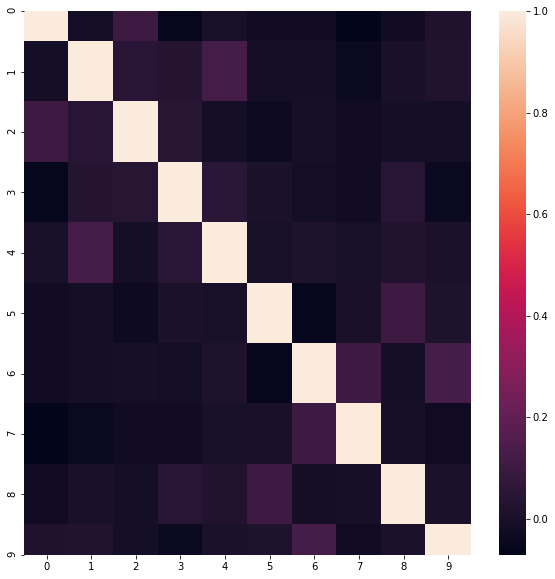

In [47]:
# Plotting the similarity between first 10 beers

x=pd.DataFrame(item_similarity_matrix[:10,:10])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(x, annot=False, ax=ax)

### Prediction for Item based similarity

In [48]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_similarity_matrix[item_similarity_matrix<0]=0
item_similarity_matrix

array([[1.        , 0.        , 0.10072355, ..., 0.        , 0.06351514,
        0.        ],
       [0.        , 1.        , 0.04281381, ..., 0.17196751, 0.        ,
        0.02764484],
       [0.10072355, 0.04281381, 1.        , ..., 0.        , 0.02052301,
        0.        ],
       ...,
       [0.        , 0.17196751, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06351514, 0.        , 0.02052301, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.02764484, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [49]:
item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_similarity_matrix)

#  ignoring the beers rated by the user by making it zero.
item_final_rating = np.multiply(item_predicted_ratings,dummy_beer_train)
item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,3.98,3.88,5.09,0.00,4.48,3.22,3.58,2.18,4.50,5.15,0.00,3.91,3.62,0.00,2.56,5.07,4.43,3.44,5.32,5.41,5.82,1.73,5.11,0.00,5.43,...,2.26,1.52,3.15,2.83,2.71,2.79,2.48,1.40,1.94,2.85,2.47,1.69,2.37,1.56,1.80,5.04,3.93,3.19,1.92,2.20,2.18,2.27,1.73,2.94,4.31
3Vandoo,1.48,1.27,1.67,1.59,2.35,1.08,1.62,1.23,1.65,2.43,1.80,0.00,2.27,1.47,1.71,0.00,2.22,1.49,0.83,0.00,1.95,0.14,1.25,1.28,2.40,...,0.45,0.36,1.07,1.10,0.55,0.64,0.97,1.72,0.63,0.56,0.43,0.59,0.40,0.30,1.34,1.51,0.95,0.61,0.95,0.31,1.50,2.07,0.28,0.70,0.65
99bottles,2.82,3.20,3.08,2.96,3.59,4.36,3.06,2.28,4.82,3.36,0.00,0.00,4.71,3.49,3.10,2.11,3.69,3.58,3.69,3.36,2.91,1.28,4.02,2.11,4.38,...,2.13,0.99,2.84,3.13,2.06,2.34,1.19,1.96,2.83,1.24,2.91,1.73,1.44,0.95,1.72,2.20,1.63,0.94,1.13,1.66,1.20,2.07,2.41,1.63,1.76
ADR,10.40,8.58,11.61,7.89,9.19,10.38,7.71,8.77,0.00,10.66,9.85,11.76,0.00,0.00,0.00,6.64,10.14,12.42,11.39,10.72,9.81,4.08,8.69,8.59,9.29,...,4.45,3.06,6.99,8.52,4.81,8.19,3.56,2.49,5.68,3.81,5.26,3.66,4.12,4.58,3.29,7.03,8.38,8.47,4.93,6.19,4.79,6.77,4.75,4.44,6.55
ADZA,3.91,4.55,5.55,3.55,5.12,4.57,3.03,4.04,5.48,0.00,4.21,5.23,3.38,6.00,4.90,4.62,4.94,5.93,6.30,4.32,5.19,2.15,4.91,2.64,5.64,...,2.87,1.86,5.21,3.56,0.00,6.70,3.39,1.94,3.52,3.44,2.90,2.72,2.17,2.65,1.47,4.67,2.64,3.38,3.91,2.47,1.89,4.56,3.09,3.43,3.20


In [50]:
# Top 5 beers for user 'cokes'
item_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
7879    20.32
1876    19.81
53899   19.61
412     19.17
33467   18.23
Name: cokes, dtype: float64

Beers with beer IDs 7879, 1876, 53899, 412 & 33467 are the top 5 recommended beers for user 'Cokes'

In [51]:
# Top 5 beers for user 'genog'
item_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
2263    7.60
14954   7.42
56973   7.34
1093    7.00
15617   6.98
Name: genog, dtype: float64

Beers with beer IDs 2263, 14954, 56973, 1093 & 15617 are the top 5 recommended beers for user 'genog'

In [52]:
# Top 5 beers for user 'giblet'
item_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
1093    6.56
321     6.34
27804   6.25
729     6.17
148     6.04
Name: giblet, dtype: float64

Beers with beer IDs 1093, 321, 27804, 729 & 148 are the top 5 recommended beers for user 'giblet'

### Model evaluation

#### Evaluation for the user based similarity model

In [53]:
test_beer_features = beer_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

mean = np.nanmean(test_beer_features, axis=1)
test_subtracted_df = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_similarity_matrix = 1 - pairwise_distances(test_subtracted_df.fillna(0), metric='cosine')
test_user_similarity_matrix[np.isnan(test_user_similarity_matrix)] = 0
print(test_user_similarity_matrix)

[[ 1.          0.0421574   0.         ...  0.          0.02264559
   0.10251879]
 [ 0.0421574   1.         -0.00526408 ...  0.          0.01819285
   0.        ]
 [ 0.         -0.00526408  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.02264559  0.01819285  0.         ...  0.          1.
   0.        ]
 [ 0.10251879  0.          0.         ...  0.          0.
   1.        ]]


In [54]:
test_user_similarity_matrix[test_user_similarity_matrix<0]=0
test_user_predicted_ratings = np.dot(test_user_similarity_matrix, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[0.35792949, 5.87696585, 1.37908116, ..., 0.25065998, 0.0455105 ,
        0.7225149 ],
       [0.79116836, 0.98427529, 0.68048542, ..., 0.94512952, 0.98253773,
        0.00166918],
       [0.58759482, 1.83261689, 1.01680108, ..., 0.18584028, 0.14668592,
        0.12596147],
       ...,
       [0.12936171, 0.78332173, 1.06735227, ..., 0.1774825 , 0.08608212,
        0.60989709],
       [0.25595102, 1.40847765, 0.71727619, ..., 0.94906321, 0.91585464,
        0.99886245],
       [0.29721709, 1.0925385 , 0.93241104, ..., 0.13246781, 0.1175434 ,
        0.70858867]])

In [55]:
# Predicting for the beers rated by user
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_beer_test)
test_user_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,0.00,5.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.44,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3Vandoo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99bottles,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.88,0.00,0.00,0.00,0.00,0.00,4.60,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADZA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [56]:
# Calculating the RMSE for beers rated by the user. The range will be normalized to (1,5) range
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))

test_ = beer_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.4455274725120764


#### Evaluation for item based similarity model

In [57]:
test_beer_features = beer_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_subtracted_df = (test_beer_features.T-mean).T

test_item_similarity_matrix = 1 - pairwise_distances(test_subtracted_df.fillna(0), metric='cosine')
test_item_similarity_matrix[np.isnan(test_item_similarity_matrix)] = 0
test_item_similarity_matrix[test_item_similarity_matrix<0]=0

test_item_predicted_ratings = (np.dot(test_item_similarity_matrix, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_beer_test)
test_item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,66,67,69,73,...,68772,68916,68958,68960,69070,69363,69407,70102,70910,71369,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fastz28,0.00,4.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.39,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3Vandoo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
99bottles,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.58,0.00,0.00,0.00,0.00,0.00,8.58,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADZA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [58]:
test_ = beer_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))

total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1274211901693056


RMSE for user based similarity model (1.45) is lower than item based similarity model (2.13). It can be concluded that user based similarity model performs better.

### Assignment Summary

1. Value of N used to filter beers having at least N reviews is 50.
2. The data was also filtered for users which have given at least 100 reviews.
The following observations were made after filtering the data as per point 1 and 2
3. Unique values of ratings that are given are 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0
4. 4 is the rating received by the maximum number of beers, 1 rating is given to the least number of beers.
5. The average beer ratings range from 1.73 to 4.63
6. The average ratings given by users range from 3.04 to 4.44.
7. The average number of ratings given to beers is 74.0
8. The average number of ratings given by a user is 132.0
9. User based similarity recommendations
    <br/>Beers with beer IDs 2093, 412, 1093, 1904 & 34 are the top 5 recommended beers for user 'Cokes'
    <br/>Beers with beer IDs 412, 1005, 1093, 1708 & 1160 are the top 5 recommended beers for user 'genog'
    <br/>Beers with beer IDs 412, 1904, 1093, 92 & 1013 are the top 5 recommended beers for user 'giblet'
10. Item based similarity recommendations
    <br/>Beers with beer IDs 7879, 1876, 53899, 412 & 33467 are the top 5 recommended beers for user 'Cokes'
    <br/>Beers with beer IDs 2263, 14954, 56973, 1093 & 15617 are the top 5 recommended beers for user 'genog'
    <br/>Beers with beer IDs 1093, 321, 27804, 729 & 148 are the top 5 recommended beers for user 'giblet'
11. RMSE for user based similarity model is ~1.45
12. RMSE for item based similarity model is ~2.13
13. User based similarity model should be deployed since it has a better fit.